https://github.com/lululxvi/deepxde/issues/384


>Hi, Lulu!
I am a beginner in this area. I am trying to modify the 'ode_system.py' to solve an ODE that describes a simple pendulum movement. I always got very large test metrics and it changed very slowly. Shall I need to add something or change the hyperparameter of the FNN?
The following is my codes, hope you can give me some advice to improve it. Thank you in advance!

>Try TimeDomain(0, 1) first

Compiling model...
Building feed-forward neural network...
'build' took 0.040942 s

'compile' took 0.285937 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric   
0         [5.02e-03, nan]         [5.02e-03, nan]         [9.18e-01]    
1000      [1.39e-09, nan]         [1.21e-09, nan]         [4.67e+00]    
2000      [1.26e-07, nan]         [1.24e-07, nan]         [4.67e+00]    
3000      [8.19e-09, nan]         [8.34e-09, nan]         [4.67e+00]    
4000      [5.08e-08, nan]         [5.10e-08, nan]         [4.67e+00]    
5000      [7.47e-07, nan]         [7.47e-07, nan]         [4.67e+00]    
6000      [1.02e-06, nan]         [1.02e-06, nan]         [4.67e+00]    
7000      [3.27e-05, nan]         [3.27e-05, nan]         [4.66e+00]    
8000      [1.73e-06, nan]         [1.73e-06, nan]         [4.67e+00]    
9000      [3.46e-04, nan]         [3.46e-04, nan]         [4.65e+00]    
10000     [4.08e-06, nan]         [4.08e-

AttributeError: 'NoneType' object has no attribute 'shape'

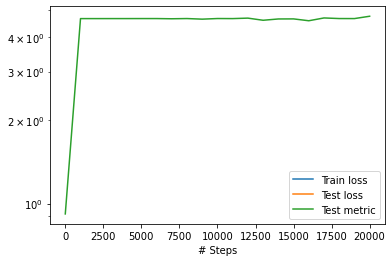

In [4]:
import deepxde as dde
import numpy as np
import tensorflow as tf

def ode_system(t, theta):
    """ODE
    theta''(t) = -g*sin(theta(t))/L
    """
    dtheta1_dt = dde.grad.jacobian(theta, t, i=0)
    dtheta2_dt = dde.grad.jacobian(dtheta1_dt, t, i=0)
    return [dtheta2_dt + tf.sin(theta)]

def boundary(_, on_initial):
    return on_initial

def func(t):
    """
    theta = cos(t)
    """
    return np.cos(t)

geom = dde.geometry.TimeDomain(0, 1)
ic1 = dde.IC(geom, np.cos, boundary, component=0)
data = dde.data.PDE(geom, ode_system, [ic1], 30, 1, solution=func, num_test=50) 

layer_size = [1] + [30] * 3 + [1]
activation = "sigmoid"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.1, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=20000)

dde.saveplot(losshistory, train_state, issave=False, isplot=True)

In [ ]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch"""
import deepxde as dde
import numpy as np


def ode_system(x, y):
    """ODE system.
    dy1/dx = y2
    dy2/dx = -y1
    """
    y1, y2 = y[:, 0:1], y[:, 1:]
    dy1_x = dde.grad.jacobian(y, x, i=0)
    dy2_x = dde.grad.jacobian(y, x, i=1)
    return [dy1_x - y2, dy2_x + y1]


def boundary(_, on_initial):
    return on_initial


def func(x):
    """
    y1 = sin(x)
    y2 = cos(x)
    """
    return np.hstack((np.sin(x), np.cos(x)))


geom = dde.geometry.TimeDomain(0, 10)
ic1 = dde.IC(geom, np.sin, boundary, component=0)
ic2 = dde.IC(geom, np.cos, boundary, component=1)
data = dde.data.PDE(geom, ode_system, [ic1, ic2], 35, 2, solution=func, num_test=100)

layer_size = [1] + [50] * 3 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.maps.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=20000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)